In [15]:
import re
import pandas as pd
import numpy as np
# from mlutils import dataset, connector
import scipy.stats
from scipy.stats import *
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm 
import seaborn as sns
import pylab as py 

In [16]:
vehicle_df = pd.read_csv('vehicles.csv')
vehicle_df.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


In [17]:
dist_names = ['weibull_min','norm','weibull_max','beta','invgauss','uniform','gamma','expon','lognorm','pearson3','triang']
columns = ['id','price','year','manufacturer','condition','odometer']
vehicle_data = vehicle_df[columns]

vehicle_data.head()

,id,price,year,manufacturer,condition,odometer
0,7240372487,35990,2010.0,chevrolet,good,32742.0
1,7240309422,7500,2014.0,hyundai,excellent,93600.0
2,7240224296,4900,2006.0,bmw,good,87046.0
3,7240103965,2000,1974.0,chevrolet,good,190000.0
4,7239983776,19500,2005.0,ford,excellent,116000.0


In [18]:

from scipy import stats
vehicle_data.isna().sum()

id                   0
price                0
year              1050
manufacturer     18220
condition       192940
odometer         55303
dtype: int64

In [22]:
def standarise(column,pct,pct_lower):
    sc = StandardScaler() 
    y = vehicle_data[column][vehicle_data[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y

In [23]:
def fit_distribution(column,pct,pct_lower):
    # Set up list of candidate distributions to use
    # See https://docs.scipy.org/doc/scipy/reference/stats.html for more
    y_std,size,y_org = standarise(column,pct,pct_lower)
    chi_square_statistics = []
    # 11 equi-distant bins of observed Data 
    percentile_bins = np.linspace(0,100,11)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions
    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)
        print("{}\n{}\n".format(dist, param))


        # Get expected counts in percentile bins
        # cdf of fitted sistrinution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
        chi_square_statistics.append(ss)


    #Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results.sort_values(['chi_square'], inplace=True)


    print ('\nDistributions listed by Betterment of fit:')
    print ('............................................')
    print (results)

In [24]:
fit_distribution('price',0.99,0.01)

(0.7632277149829556, -1.1754946479473236, 1.2882536570292253)

(-8.911690259840561e-17, 0.9999999999999997)

(0.6631696425157605, 3.733945799149187, 1.2482130514042336)



C:\Users\hkboa\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


(0.7865637172457626, 3.550740734963806, -1.1754946479473236, 5.79718335298919)

(0.535903945611452, -1.5527498969582751, 2.8974430723439992)

(-1.1754946479473234, 4.90944044709651)

(0.6976229173184187, -1.1754946479473236, 1.3056723410201334)

(-1.1754946479473234, 1.1754946479473234)

(0.7239776224010441, -1.4707748023579015, 1.154752192779032)

(2.295625645830987, 8.903804083047191e-17, 1.3492478301824717)

(4.676784334233846e-10, -1.1827976612383126, 4.917758033482377)


Distributions listed by Betterment of fit:
............................................
   Distribution    chi_square
7         expon  1.416364e+04
4      invgauss  2.596217e+04
8       lognorm  2.805792e+04
3          beta  3.013682e+04
0   weibull_min  3.990584e+04
9      pearson3  5.226114e+04
10       triang  1.623389e+05
6         gamma  2.067022e+05
1          norm  2.833109e+05
5       uniform  6.408768e+05
2   weibull_max  1.666297e+06


Text(0, 0.5, 'Frequency')

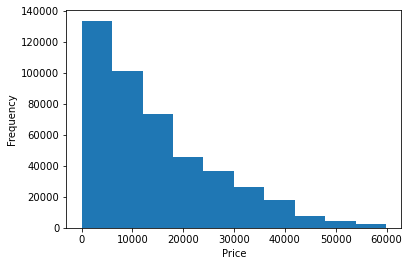

In [25]:
y_std,len_y,y = standarise('price',0.99,0.01)
plt.hist(y)
plt.xlabel("Price")
plt.ylabel("Frequency")

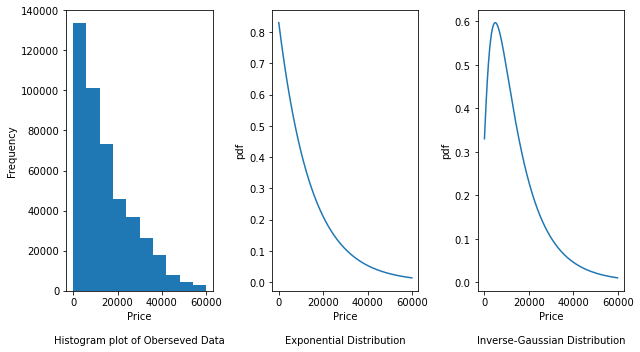

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y)
axes[0].set_xlabel('Price\n\nHistogram plot of Oberseved Data')
axes[0].set_ylabel('Frequency')
axes[1].plot(y,expon.pdf(y_std,-1.19, 1.19))
axes[1].set_xlabel('Price\n\nExponential Distribution')
axes[1].set_ylabel('pdf')
axes[2].plot(y,invgauss.pdf(y_std,0.45, -1.64, 3.61))
axes[2].set_xlabel('Price\n\nInverse-Gaussian Distribution')
axes[2].set_ylabel('pdf')
fig.tight_layout()

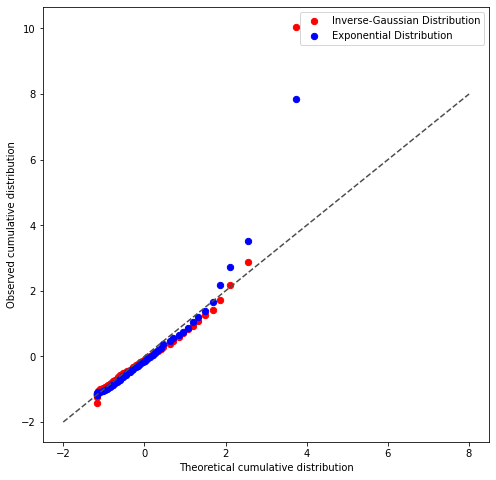

In [29]:
data_points = expon.rvs(-1.19, 1.19, size=2000)   
data_points2 = invgauss.rvs(0.45, -1.64, 3.61,size = 2000) 

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 8], [-2, 8], ls="--", c=".3")

percentile_bins = np.linspace(0,100,51)
percentile_cutoffs1 = np.percentile(y_std, percentile_bins)
percentile_cutoffs_expon= np.percentile(data_points, percentile_bins)


percentile_cutoffs_invgauss = np.percentile(data_points2, percentile_bins)


ax.scatter(percentile_cutoffs1,percentile_cutoffs_invgauss,c='r',label = 'Inverse-Gaussian Distribution',s = 40)
ax.scatter(percentile_cutoffs1,percentile_cutoffs_expon,c='b',label = 'Exponential Distribution',s = 40)


ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
ax.legend()
plt.show()

In [30]:
fit_distribution('odometer',0.99,0.01)

(0.9818556223328978, -1.5654925164506055, 1.3417153395864205)

(-4.6067742098813384e-18, 0.9999999999999999)

(11.299985620455182, 9.29041292024343, 9.72663874343157)

(1.2217405829039478, 2.4662259863761506, -1.5751082764782347, 4.716015726064862)

(0.1263726207689636, -2.9526290492352, 23.364467052069998)

(-1.5654925164506053, 4.59855705243684)

(2.754826520049602, -1.8017391517440855, 0.6540273699589)

(-1.5654925164506053, 1.5654925164506053)

(0.3294092639466634, -3.088746407409829, 2.9286318388762727)

(1.2050031729940125, -3.927375847245833e-18, 1.0855433902514364)

(0.06078393188665161, -1.6464661424790155, 4.691814144218304)


Distributions listed by Betterment of fit:
............................................
   Distribution     chi_square
3          beta    1709.284439
10       triang    2825.759668
9      pearson3   11507.198842
6         gamma   11507.646675
4      invgauss   19203.049629
8       lognorm   22232.780538
2   weibull_max   30097.586351
1          norm   7

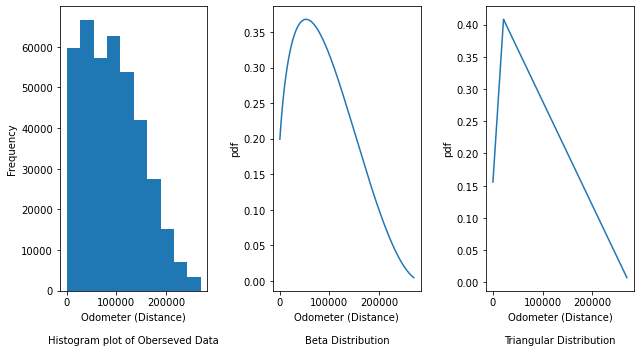

In [32]:
lst,len_lst,org_lst = standarise('odometer',0.99,0.01)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(org_lst)
axes[0].set_xlabel('Odometer (Distance)\n\nHistogram plot of Oberseved Data')
axes[0].set_ylabel('Frequency')
axes[1].plot(org_lst,beta.pdf(lst,1.51, 2.94, -1.71, 5.02))
axes[1].set_xlabel('Odometer (Distance)\n\nBeta Distribution')
axes[1].set_ylabel('pdf')
axes[2].plot(org_lst,triang.pdf(lst,.12, -1.79, 4.90))
axes[2].set_xlabel('Odometer (Distance)\n\nTriangular Distribution')
axes[2].set_ylabel('pdf')
fig.tight_layout()

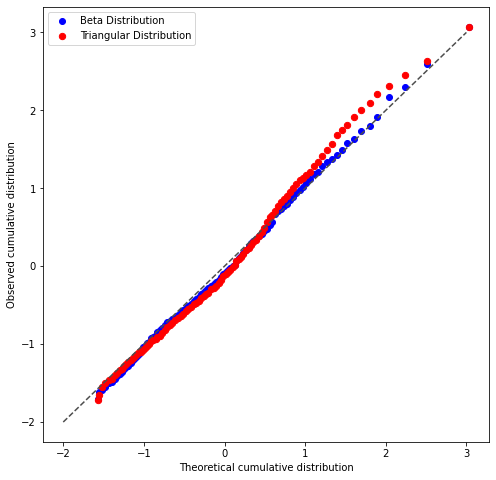

In [33]:
data_points = beta.rvs(1.51, 2.94, -1.71, 5.02,size = 1000)    
  
data_points2 = triang.rvs(.12, -1.79, 4.90,size = 1000) 

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 3], [-2, 3], ls="--", c=".3")

percentile_bins = np.linspace(0,100,101)
percentile_cutoffs1 = np.percentile(lst, percentile_bins)
percentile_cutoffs_beta = np.percentile(data_points, percentile_bins)


percentile_cutoffs_triang = np.percentile(data_points2, percentile_bins)
# print(percentile_cutoffs1,percentile_cutoffs2)

ax.scatter(percentile_cutoffs1,percentile_cutoffs_beta,c='b',label = 'Beta Distribution')
ax.scatter(percentile_cutoffs1,percentile_cutoffs_triang,c='r',label = 'Triangular Distribution',s = 40)


ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
ax.legend()
plt.show()